<a href="https://colab.research.google.com/github/unverciftci/GMR/blob/master/GenModReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization with flows

This notebook shows some first steps using flows for regression.

In [0]:
# Required packages
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions
tfb = tfp.bijectors

In [0]:
# Define a sixth-order polynomial 
x = np.linspace(-3, 5, 201, dtype=np.float32)
f = lambda x: -0.001*(x-1)*(x-5)*(x+3)*(x+2)*(x-4)*(x-2) # -1

# Unnoisy data points
X_unnoisy = f(x)
np.random.seed(1)
# Noisy data points
X = np.array([a +  0.04 * np.random.normal(0,1) for a in X_unnoisy])

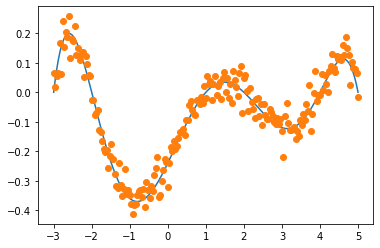

In [0]:
plt.plot(x, f(x))
plt.plot(x, X, 'o')

In [0]:
# Define the normalizing flow

num_bijectors = 8
bs=[]
for i in range(num_bijectors):
    
    shift = tf.Variable(0.0)
    scale=tf.Variable(1.0)
    bs.append(tfb.Shift(shift)(tfb.Scale(scale)))
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))
    
bijector = tfb.Chain(bs) 
dist = tfd.TransformedDistribution(distribution=
        #tfd.Uniform(low=0.0, high=1.0),bijector=bijector)
        tfd.Normal(loc=0,scale=1),bijector=bijector)

In [0]:
# Estimator of the normalizing constant

logK = tf.math.log(tf.reduce_sum(tf.math.exp(-f(x)))) 

In [0]:
# Optimization staff

optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

@tf.function #Compiles function for fast execution
def train_step(x):
    with tf.GradientTape() as tape:
        loss = tf.keras.losses.MSE(X, -dist.log_prob(x) - logK)
        gradients = tape.gradient(loss,dist.trainable_variables)     
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) 
        return loss

In [0]:
# Training

for i in range(11001):
    loss = train_step(x)
    if (i % 1000 == 0 or i < 5):
        print(i, "NLL ",loss.numpy())

0 NLL  12.139171
1 NLL  7.846362
2 NLL  8.184278
3 NLL  8.342259
4 NLL  8.350926
1000 NLL  0.0068943975
2000 NLL  0.0062676966
3000 NLL  0.0055860886
4000 NLL  0.0044771335
5000 NLL  0.003301651
6000 NLL  0.0031530305
7000 NLL  0.0030065128
8000 NLL  0.0027379135
9000 NLL  0.002587219
10000 NLL  0.0023728537
11000 NLL  0.0020884145


In [0]:
# Regressor

f_pred = -dist.log_prob(x) - logK

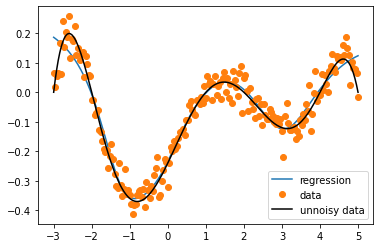

In [0]:
plt.plot(x, f_pred, label='regression')
plt.plot(x, X, 'o', label='data')
plt.plot(x, f(x), 'black', label='unnoisy data')
plt.legend()

Confidence Interval

In [0]:
sh = np.mean(bijector.inverse(x))
sc = np.std(bijector.inverse(x))
sf_and_sc = (tfb.Shift(sh))(tfb.Scale(sc))

base=tfd.Normal(loc=0,scale=1)

In [0]:
c = sf_and_sc.forward(1)-sf_and_sc.forward(0)
cu_pred = -base.log_prob(bijector.inverse(x)+c) - bijector.inverse_log_det_jacobian(x, event_ndims=int(0)) - logK
cd_pred = -base.log_prob(bijector.inverse(x)-c) - bijector.inverse_log_det_jacobian(x, event_ndims=int(0)) - logK

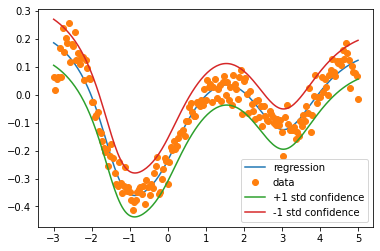

In [0]:
plt.plot(x, f_pred, label='regression')
plt.plot(x, X, 'o', label='data')
plt.plot(x, cu_pred, label='+1 std confidence')
plt.plot(x, cd_pred, label='-1 std confidence')
plt.legend()

Bijection

Text(0, 0.5, 'z')

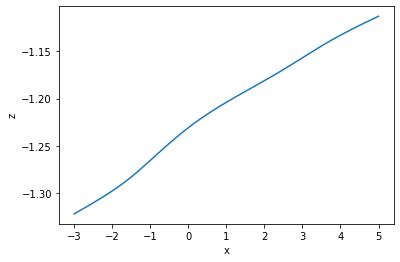

In [0]:
plt.plot(x, bijector.inverse(x))
plt.xlabel('x')
plt.ylabel('z')

**Credit:** Flow architecture is adopted from the book [Probabilistic Deep Learning book](https://tensorchiefs.github.io/dl_book/)